In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('ml-latest-small/ratings.csv')

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
user_movie_count = df.groupby(['userId']).count().reindex()
user_movie_count.head()

,movieId,rating,timestamp
userId,,,
1,232,232,232
2,29,29,29
3,39,39,39
4,216,216,216
5,44,44,44


In [5]:
movie_ids = list(df.movieId.unique())
movie_ids.sort()
selected_users = list(user_movie_count[user_movie_count.rating>20].index)
print(len(selected_users))
print(selected_users[:5])
df = df[df.userId.isin(selected_users)]

596
[1, 2, 3, 4, 5]


In [6]:
test = pd.DataFrame(columns = df.columns)
train = df.copy()
for id in selected_users:
    ndf = df[df.userId == id]
    tmp = ndf.iloc[:ndf.shape[0]//4,:]
    test =pd.concat([test,tmp],ignore_index=True)
    movie_ids = list(tmp.movieId)
    for mid in movie_ids:
        train.loc[(train.userId == id)&(train.movieId==mid),'rating'] = 0  

In [7]:
print("train size: ",train.shape)
print("test size: ", test.shape)

train size:  (100556, 4)
test size:  (24913, 4)


In [8]:
user_item = pd.pivot_table(train,values = 'rating',index=['userId'],columns = ['movieId'],fill_value=0)

In [11]:
def get_movie_index(movie_id):
    return movie_ids.index(movie_id)
def get_user_index(user_id):
    return selected_users.index(user_id)
user_item.iloc[get_user_index(2),get_movie_index(5)]

ValueError: 5 is not in list

In [137]:
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
    return P, Q.T

In [300]:
R = [
    [5,3,0,1],
    [4,0,0,1],
    [1,1,0,5],
    [1,0,0,4],
    [0,1,5,4],
    ]

R = np.array(user_item)

N = len(R)
M = len(R[0])
K = 2

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K)


In [301]:
np.dot(nP, nQ.T)

array([[ 2.14580598,  3.02267694,  2.45248654, ...,  4.03749722,
         4.07435343,  4.77272143],
       [ 1.95801291,  2.31375003,  1.82648228, ...,  3.30137406,
         3.36388875,  3.87496438],
       [-0.36574701,  1.81231564,  1.7365511 , ...,  1.3166208 ,
         1.15905796,  1.70086173],
       ...,
       [ 1.4019027 ,  2.45975889,  2.0512035 , ...,  3.05551932,
         3.04807651,  3.64203223],
       [ 1.71144789,  2.19971001,  1.76062572, ...,  3.03837993,
         3.0814971 ,  3.57856074],
       [ 1.93805735,  2.54043518,  2.03953692, ...,  3.48329307,
         3.52890419,  4.10582759]])

In [145]:
from sklearn.decomposition import NMF

In [286]:
R = [
    [5,3,0,1],
    [4,0,0,1],
    [1,1,0,5],
    [1,0,0,4],
    [0,1,5,4],
    ]

R = np.array(R)

N = len(R)
M = len(R[0])
K = 2

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

In [287]:
model = NMF(n_components=2,init='nndsvdar',alpha = 0.0002,max_iter = 5000)#, solver='mu',,beta_loss = 0.02

In [288]:
W = model.fit_transform(R)
Q = model.fit_transform(R.T)

In [289]:
#np.argsort(r[0,:])[::-1]
r = np.dot(W, Q.T)
print(r)

[[6.31573814 2.39508596 0.         1.74849907]
 [4.21098723 1.59691174 0.         1.16580312]
 [1.57775063 0.98870796 1.70538754 3.57085054]
 [1.17921089 0.75307538 1.33626773 2.78217056]
 [0.         0.56869575 2.48433098 4.56554661]]


In [297]:
sum(sum(abs(abs(r)-R)))

15.36533632350893

In [278]:
from sklearn.decomposition import TruncatedSVD
svd1 = TruncatedSVD(n_components=3, n_iter=500)
svd2 = TruncatedSVD(n_components=3, n_iter=500)

In [279]:
svd1.fit(R)
svd2.fit(R.T)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=500,
       random_state=None, tol=0.0)

In [280]:
print(svd1.explained_variance_ratio_.sum())
print(svd2.explained_variance_ratio_.sum())

0.9435618011861971
0.9516450659966224


In [281]:
W = svd1.transform(R)
Q = svd2.transform(R.T)

In [282]:
r = np.dot(W,Q.T)
print(r)

[[ 3.79592137e+01  1.58392123e+01  2.24962843e+00  1.62926844e+01]
 [ 2.50805920e+01  1.01316363e+01 -2.71157766e-03  1.23316701e+01]
 [ 1.45023857e+01  7.96296112e+00  8.72672992e+00  3.88610359e+01]
 [ 1.09481410e+01  5.92484593e+00  6.18790975e+00  3.06147085e+01]
 [ 5.23038710e+00  9.19431537e+00  3.04959616e+01  3.85232104e+01]]


In [315]:
import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users,dtype=np.float64)
        self.b_i = np.zeros(self.num_items,dtype=np.float64)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [339]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])
R = np.array(user_item)
mf = MF(R, K=10, alpha=0.001, beta=0.01, iterations=200)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)

Iteration: 10 ; error = 247.0071
Iteration: 20 ; error = 239.9177
Iteration: 30 ; error = 235.7270
Iteration: 40 ; error = 232.6175
Iteration: 50 ; error = 230.0171
Iteration: 60 ; error = 227.6430
Iteration: 70 ; error = 225.3250
Iteration: 80 ; error = 222.9218
Iteration: 90 ; error = 220.3200
Iteration: 100 ; error = 217.4239
Iteration: 110 ; error = 214.1760
Iteration: 120 ; error = 210.5677
Iteration: 130 ; error = 206.6470
Iteration: 140 ; error = 202.5168
Iteration: 150 ; error = 198.3061
Iteration: 160 ; error = 194.1394
Iteration: 170 ; error = 190.1098
Iteration: 180 ; error = 186.2798
Iteration: 190 ; error = 182.6813
Iteration: 200 ; error = 179.3171

P x Q:
[[4.31335307 4.26009588 4.17952367 ... 4.14315139 4.12162106 4.25694641]
 [3.52418421 3.57995049 3.59607691 ... 3.50296246 3.50178425 3.65321234]
 [2.76340611 2.77133026 2.7453455  ... 2.75083099 2.72291237 3.03618502]
 ...
 [3.60328256 3.16586625 2.89685653 ... 3.27939116 3.16352586 3.2285583 ]
 [3.3196109  3.26626998 

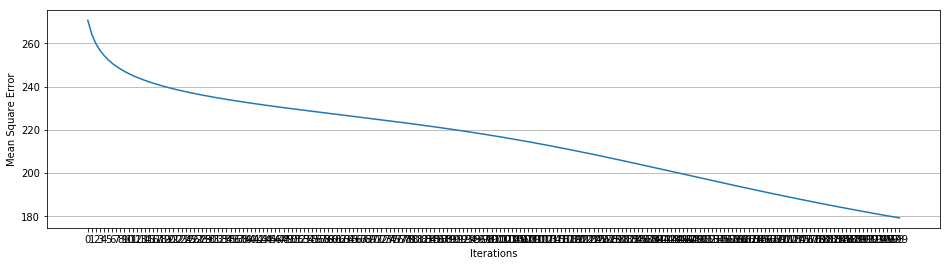

In [350]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

In [341]:
predicted_matrix = mf.full_matrix()

In [342]:
predicted_matrix[get_user_index(2),get_movie_index(58559)]

4.1360610108166584

In [347]:
def get_ranked_item_list(user_id,n = 10):
    result = np.argsort(predicted_matrix[get_user_index(user_id),:])[::-1]
    result = [movie_ids[i] for i in result]
    return result[:n]

In [349]:
user_id = 1
get_ranked_item_list(user_id)

[1266, 1196, 3451, 1233, 750, 1230, 356, 71899, 318, 4306]

In [353]:
test.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [367]:
#RMSE score for test data.
score = 0
for i in range(test.shape[0]):
    actual = test.iloc[i,2]
    predicted = predicted_matrix[get_user_index(test.iloc[i,0]),get_movie_index(test.iloc[i,1])]
    score = score + (actual-predicted)**2
print(np.sqrt(score/test.shape[0]))

0.9399231078700301
